In [1]:
import pymc as pm
import arviz as az
import pandas as pd
from scipy.stats import beta, gamma, norm, cauchy
from scipy import io as sio
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde, ttest_rel, ttest_ind
from scipy.optimize import minimize
from pytensor import tensor as pt 

# 16 The BART Model of Risk Taking

BART：气球样风险任务 Ballon Analogue Risk Task
- 选择：按压气球获取更多的钱（可能会爆炸），或者收手
- data中，prob是气球爆炸概率%，trial是试次，pumps是按压次数，cash是存储金额
- 将by_trial转化成by_decision的数据

(array([33., 16., 24., 10.,  5.,  1.,  1.,  0.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 <BarContainer object of 8 artists>)

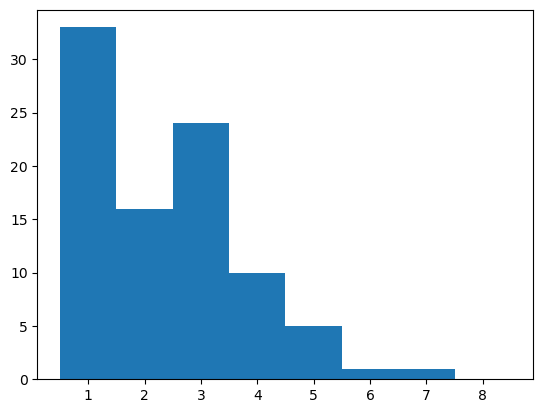

In [54]:


def short_to_wide(data):
    cash = np.asarray(data['cash']!=0, dtype=int)
    npumps = np.asarray(data['pumps'], dtype=int)
    options = cash + npumps
    d = np.full([ntrials,30], np.nan)
    k = np.full([ntrials,30], np.nan)
    # response vector
    for j, ipumps in enumerate(npumps):
        inds = np.arange(options[j],dtype=int)
        k[j,inds] = inds+1
        if ipumps > 0:
            d[j,0:ipumps] = 0
        if cash[j] == 1:
            d[j,ipumps] = 1      
    indexmask = np.isfinite(d)
    d = d[indexmask]
    k = k[indexmask]
    return d, k

data = pd.read_csv('./Data/GeorgeSober.txt', sep = '\t')
p, ntrials = 0.15, 90
d_obs, k = short_to_wide(data)
plt.hist(data.pumps, bins = np.arange(9) + 0.5)

## 16.1 The BART Model

- 最优决策次数是 $w = -\frac{\gamma^+}{\log(1-p)}$, $\gamma^+$ 衡量风险偏好
- 选择概率是 $\theta = \frac{1}{1 + \exp(\beta(k-w))}$, $\beta$ 衡量决策敏感性



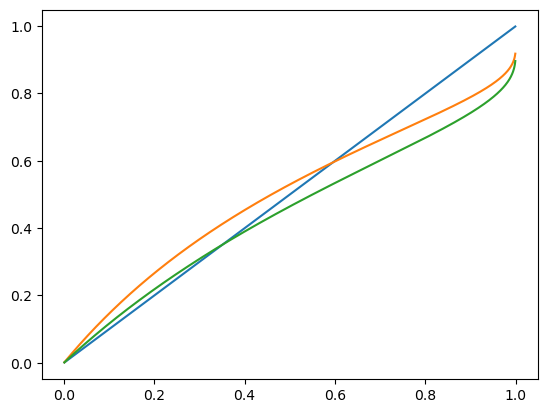

In [39]:
# 基于这样的概率扭曲函数
x = np.arange(0.001, 1, 0.001)
plt.plot(x, x)
for gamma in [0.615, 0.799]:
    plt.plot(x, 1/(1-(gamma/np.log(1-x))))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, beta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.


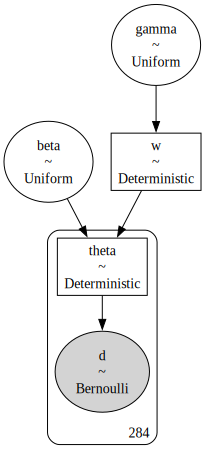

In [33]:
with pm.Model() as BART:
    gamma = pm.Uniform('gamma', lower = 0, upper = 10)
    beta = pm.Uniform('beta', lower = 0, upper = 10)
    w = pm.Deterministic('w', -gamma/pt.log(1-p))
    theta = pm.Deterministic('theta', 1 - 1/(1+pt.exp(beta * (k - w))))
    d = pm.Bernoulli('d', p = theta, observed = d_obs)
    trace = pm.sample(2000)
pm.model_to_graphviz(BART)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma,0.700,0.051,0.615,0.799,0.001,0.001,2374.0,3024.0,1.0
beta,0.742,0.115,0.528,0.955,0.002,0.001,2378.0,3206.0,1.0
w,4.307,0.312,3.785,4.917,0.007,0.005,2374.0,3024.0,1.0


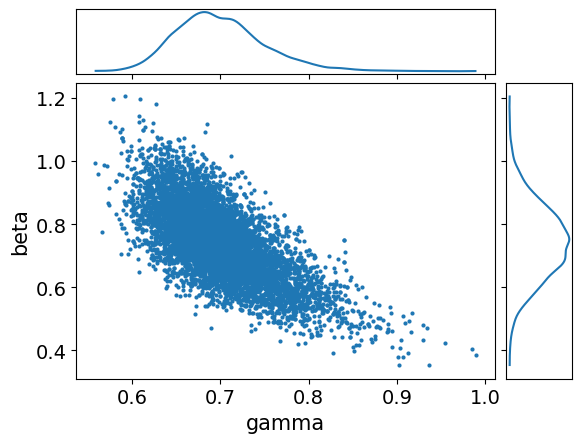

In [57]:
az.plot_pair(trace, var_names=['gamma', 'beta'], marginals=True)
az.summary(trace, var_names= ['gamma', 'beta', 'w'])

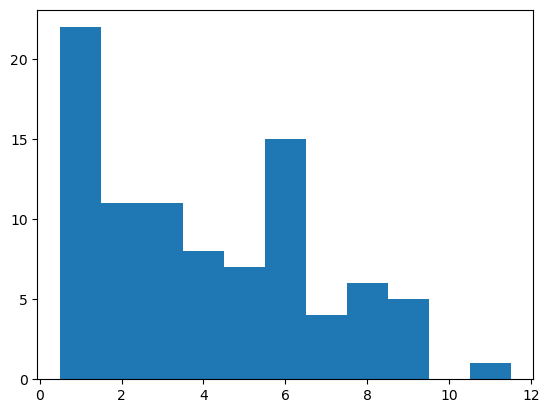

In [59]:
# Exercise 16.1.1
data = pd.read_csv('./Data/BillSober.txt', sep = '\t')
plt.hist(data.pumps, bins = np.arange(12) + 0.5)
p, ntrials = 0.15, 90
d_obs, k = short_to_wide(data)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, beta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma,1.573,0.123,1.367,1.816,0.003,0.003,2036.0,1984.0,1.0
beta,0.480,0.076,0.341,0.623,0.002,0.001,2050.0,2260.0,1.0
w,9.680,0.758,8.411,11.175,0.018,0.016,2036.0,1984.0,1.0


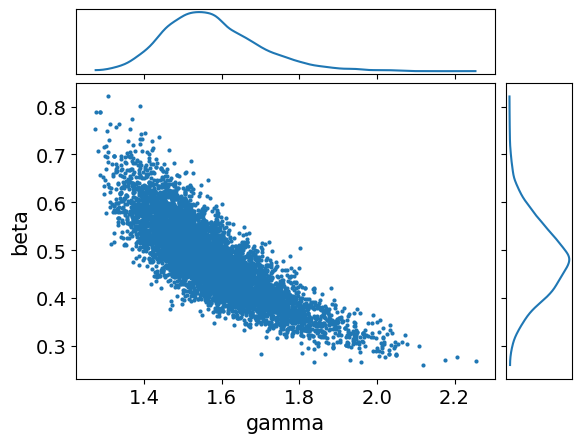

In [60]:
with pm.Model() as BART:
    gamma = pm.Uniform('gamma', lower = 0, upper = 10)
    beta = pm.Uniform('beta', lower = 0, upper = 10)
    w = pm.Deterministic('w', -gamma/pt.log(1-p))
    theta = pm.Deterministic('theta', 1 - 1/(1+pt.exp(beta * (k - w))))
    d = pm.Bernoulli('d', p = theta, observed = d_obs)
    trace = pm.sample(2000)
pm.model_to_graphviz(BART)
az.plot_pair(trace, var_names=['gamma', 'beta'], marginals=True)
az.summary(trace, var_names= ['gamma', 'beta', 'w'])

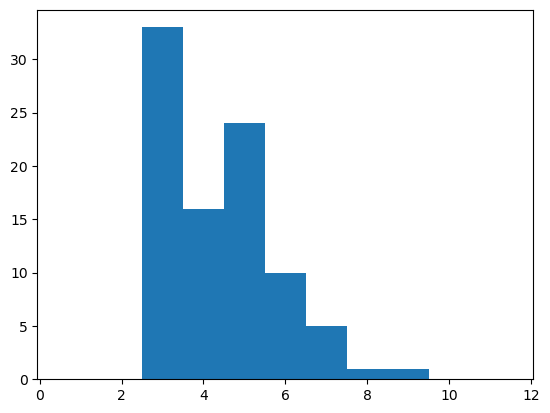

In [61]:
# Exercise 16.1.2
# 全部加两次，风险偏好大幅提高
data = pd.read_csv('./Data/GeorgeSober.txt', sep = '\t')
data['pumps'] = data['pumps'] + 2
plt.hist(data.pumps, bins = np.arange(12) + 0.5)
p, ntrials = 0.15, 90
d_obs, k = short_to_wide(data)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, beta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma,0.999,0.039,0.929,1.077,0.001,0.001,3558.0,3609.0,1.0
beta,0.897,0.105,0.704,1.097,0.002,0.001,3543.0,4211.0,1.0
w,6.148,0.242,5.716,6.628,0.004,0.003,3558.0,3609.0,1.0


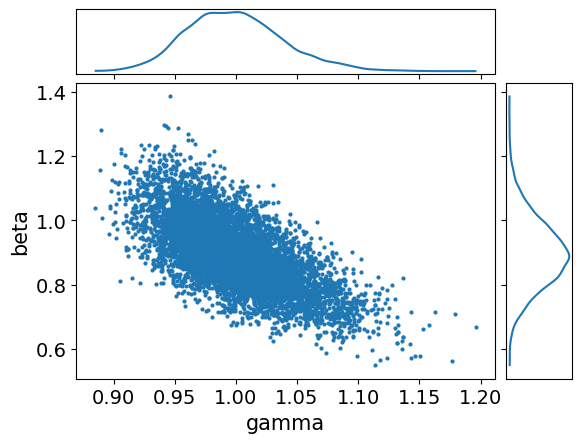

In [62]:
with pm.Model() as BART:
    gamma = pm.Uniform('gamma', lower = 0, upper = 10)
    beta = pm.Uniform('beta', lower = 0, upper = 10)
    w = pm.Deterministic('w', -gamma/pt.log(1-p))
    theta = pm.Deterministic('theta', 1 - 1/(1+pt.exp(beta * (k - w))))
    d = pm.Bernoulli('d', p = theta, observed = d_obs)
    trace = pm.sample(2000)
pm.model_to_graphviz(BART)
az.plot_pair(trace, var_names=['gamma', 'beta'], marginals=True)
az.summary(trace, var_names= ['gamma', 'beta', 'w'])

## 16.2 A Hierarchical Extension of the BART model

In [109]:
def get_data(name):
    ds, ks, pumps = [], [], []
    for idx, condition in enumerate(['Sober', 'Tipsy', 'Drunk']):
        file = './Data/' + name + condition + '.txt'
        data = pd.read_csv(file, sep = '\t')
        d_obs, k = short_to_wide(data)
        pumps.append(data.pumps.values)
        ds.append(d_obs)
        ks.append(k)
    lens = [len(d) for d in ds]
    conds = np.repeat(np.array([0, 1, 2], dtype = np.int8), lens)
    ds = np.concatenate(ds)
    ks = np.concatenate(ks)
    return conds, ds, ks, pumps
conds, ds, ks, pumps = get_data('George')

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_gamma, sigma_gamma, mu_beta, sigma_beta, gamma, beta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 61 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.


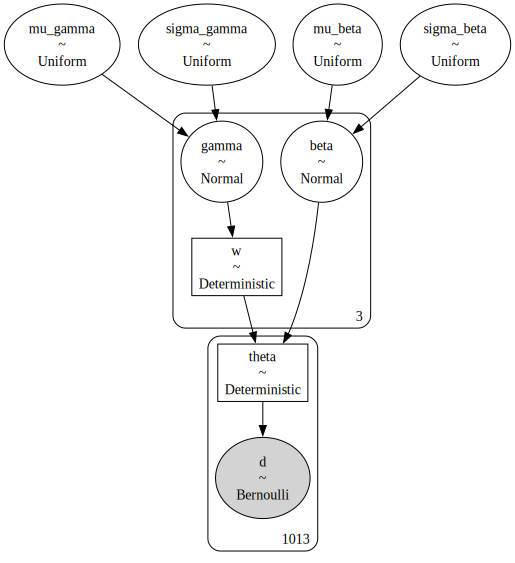

In [93]:
with pm.Model() as BART2:
    mu_gamma = pm.Uniform('mu_gamma', lower = 0, upper = 10)
    sigma_gamma = pm.Uniform('sigma_gamma', lower = 0, upper = 2)
    mu_beta = pm.Uniform('mu_beta', lower = 0, upper = 10)
    sigma_beta = pm.Uniform('sigma_beta', lower = 0, upper = 2)

    gamma = pm.Normal('gamma', mu = mu_gamma, sigma = sigma_gamma, shape = 3)
    w = pm.Deterministic('w', -gamma/pt.log(1-p))
    beta = pm.Normal('beta', mu = mu_beta, sigma = sigma_beta, shape = 3)

    theta = pm.Deterministic('theta', 1 - 1/(1 + pt.exp(pt.take(beta, conds) * (ks - pt.take(w, conds)))))
    d = pm.Bernoulli('d', p = theta, observed = ds)
    trace = pm.sample(2000)

pm.model_to_graphviz(BART2)


    
    
    



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma[0],0.710,0.055,0.616,0.819,0.001,0.001,3510.0,2269.0,1.0
gamma[1],0.995,0.039,0.920,1.065,0.001,0.000,4127.0,4256.0,1.0
gamma[2],1.104,0.128,0.893,1.345,0.002,0.002,3432.0,3638.0,1.0
beta[0],0.721,0.114,0.509,0.935,0.002,0.001,3645.0,3253.0,1.0
beta[1],0.951,0.118,0.731,1.167,0.002,0.001,3830.0,4765.0,1.0
beta[2],0.393,0.075,0.254,0.533,0.001,0.001,3392.0,4007.0,1.0


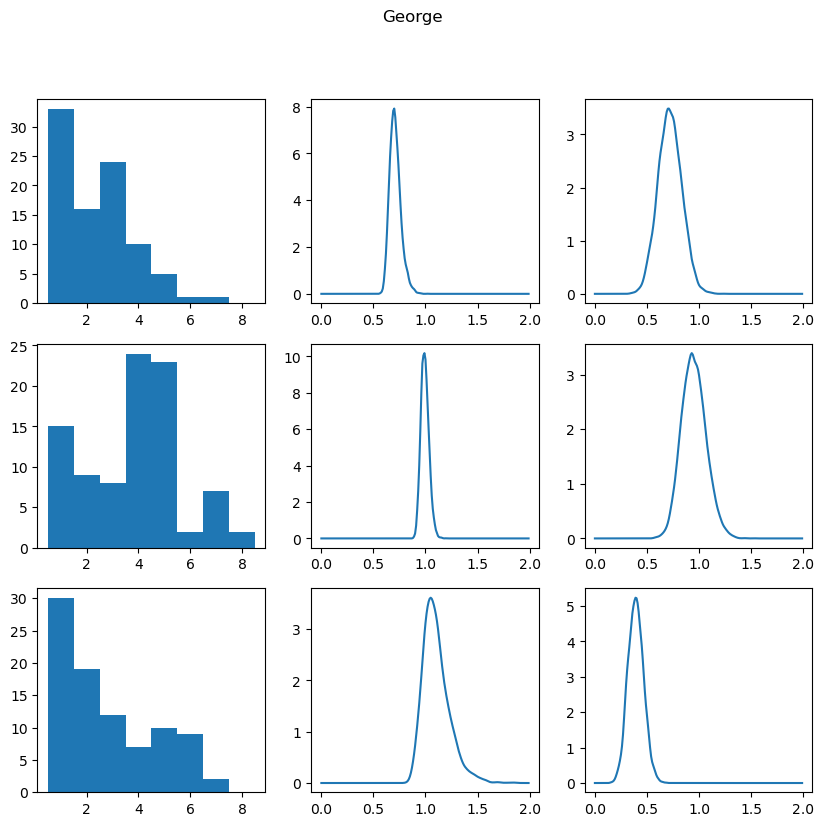

In [123]:
# 发现从清醒到微醺，风险偏好增强，一致性不变；从微醺到酒醉，风险偏好不变，随机性增强
gamma_trace = trace.posterior['gamma'].values.reshape(-1, 3)
beta_trace = trace.posterior['beta'].values.reshape(-1, 3)
fig, axes = plt.subplots(3, 3, figsize = (10, 9))
x = np.arange(0, 2, 0.01)
for i in range(3):
    axes[i][0].hist(pumps[i], bins = np.arange(9) + 0.5)
    gamma_kde = gaussian_kde(gamma_trace[:, i])
    axes[i][1].plot(x, gamma_kde(x))
    beta_kde = gaussian_kde(beta_trace[:, i])
    axes[i][2].plot(x, beta_kde(x))
plt.suptitle('George')
az.summary(trace, var_names=['gamma', 'beta'])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_gamma, sigma_gamma, mu_beta, sigma_beta, gamma, beta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 99 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma[0],1.603,0.136,1.366,1.851,0.002,0.003,3987.0,3271.0,1.0
gamma[1],1.621,0.117,1.424,1.847,0.002,0.002,4155.0,3633.0,1.0
gamma[2],2.642,0.448,1.954,3.472,0.008,0.009,3364.0,3358.0,1.0
beta[0],0.462,0.074,0.326,0.606,0.001,0.001,4035.0,3795.0,1.0
beta[1],0.476,0.070,0.347,0.604,0.001,0.001,4086.0,3886.0,1.0
beta[2],0.202,0.043,0.120,0.280,0.001,0.001,3354.0,3369.0,1.0


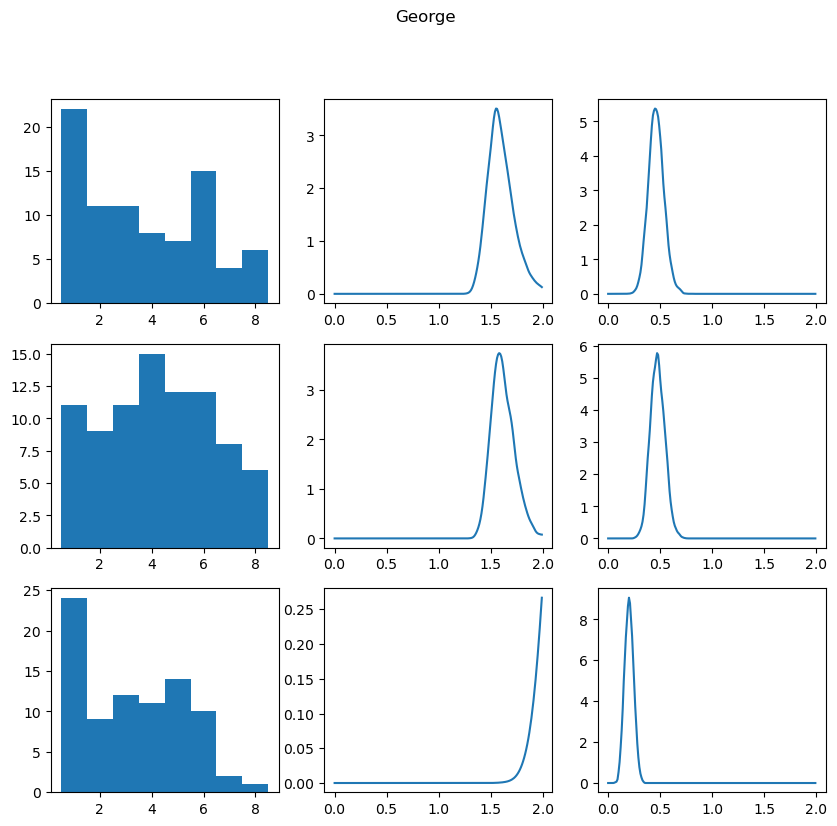

In [125]:
conds, ds, ks, pumps = get_data('Bill')
with pm.Model() as BART2:
    mu_gamma = pm.Uniform('mu_gamma', lower = 0, upper = 10)
    sigma_gamma = pm.Uniform('sigma_gamma', lower = 0, upper = 2)
    mu_beta = pm.Uniform('mu_beta', lower = 0, upper = 10)
    sigma_beta = pm.Uniform('sigma_beta', lower = 0, upper = 2)

    gamma = pm.Normal('gamma', mu = mu_gamma, sigma = sigma_gamma, shape = 3)
    w = pm.Deterministic('w', -gamma/pt.log(1-p))
    beta = pm.Normal('beta', mu = mu_beta, sigma = sigma_beta, shape = 3)

    theta = pm.Deterministic('theta', 1 - 1/(1 + pt.exp(pt.take(beta, conds) * (ks - pt.take(w, conds)))))
    d = pm.Bernoulli('d', p = theta, observed = ds)
    trace = pm.sample(2000)

# 发现从清醒到微醺，风险偏好增强，一致性不变；从微醺到酒醉，风险偏好不变，随机性增强
gamma_trace = trace.posterior['gamma'].values.reshape(-1, 3)
beta_trace = trace.posterior['beta'].values.reshape(-1, 3)
fig, axes = plt.subplots(3, 3, figsize = (10, 9))
x = np.arange(0, 2, 0.01)
for i in range(3):
    axes[i][0].hist(pumps[i], bins = np.arange(9) + 0.5)
    gamma_kde = gaussian_kde(gamma_trace[:, i])
    axes[i][1].plot(x, gamma_kde(x))
    beta_kde = gaussian_kde(beta_trace[:, i])
    axes[i][2].plot(x, beta_kde(x))
plt.suptitle('George')
az.summary(trace, var_names=['gamma', 'beta'])